## Necessary Imports

In [3]:
import numpy as np
import pandas as pd
import IPython.display as i_dis
import os
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import tqdm
import glob
import pickle

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 300


import tensorflow as tf
import sklearn
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

MAIN_DIR = ".."
DATA_DIR = os.path.join(MAIN_DIR,"dataset","recordings")
# SAMPLE_DIR = os.path.join(MAIN_DIR,"samples")
LABELS = ["ZERO","ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT","NINE"]
SAMPLE_RATE = 8000 #Hz
FIG_DIR = os.path.join(MAIN_DIR,"Figures")
os.makedirs(FIG_DIR,exist_ok=True)
LENGTH = 4000

print(os.listdir(MAIN_DIR))
print()

['env', '.gitignore', 'README.md', 'dataset', 'Models', 'requirements.txt', 'test data', 'Figures', 'samples', '.git', 'codes']



## Explore Dataset

In [4]:
print("Play a sample wavfile from the datset:")
i_dis.Audio(os.path.join(DATA_DIR,"0_theo_8.wav"))

Play a sample wavfile from the datset:


### Import Dataset

In [5]:
def fetch_data(**kwargs):
    audio = []
    labels = []
    for file in tqdm.tqdm(os.listdir(DATA_DIR),desc="Reading Data ... "):
        path = os.path.join(DATA_DIR,file)
        a, SR = librosa.load(path,sr=None)
        a, index = librosa.effects.trim(a,top_db=20,frame_length=256, hop_length=64)
        
        if(kwargs):
            length = kwargs["length"]
            if(len(a)>length):
                a = a[:length]
            elif(len(a)<length):
                a = np.pad(a,(0,length-len(a)),constant_values=(0,0))
        audio.append(a)
        labels.append(file[0])
    return np.array(audio),SR,np.array(labels)

In [6]:
audios, SR, labels = fetch_data()
# audios, SR, labels = fetch_data(length=4000)


Reading Data ... : 100%|██████████| 2000/2000 [00:01<00:00, 1760.20it/s]


In [7]:
print("Sampling Rate: ",SR)
print("Labels: ",labels[:5])
print("Total Audio Files: ",len(audios))

Sampling Rate:  8000
Labels:  ['9' '1' '8' '0' '2']
Total Audio Files:  2000


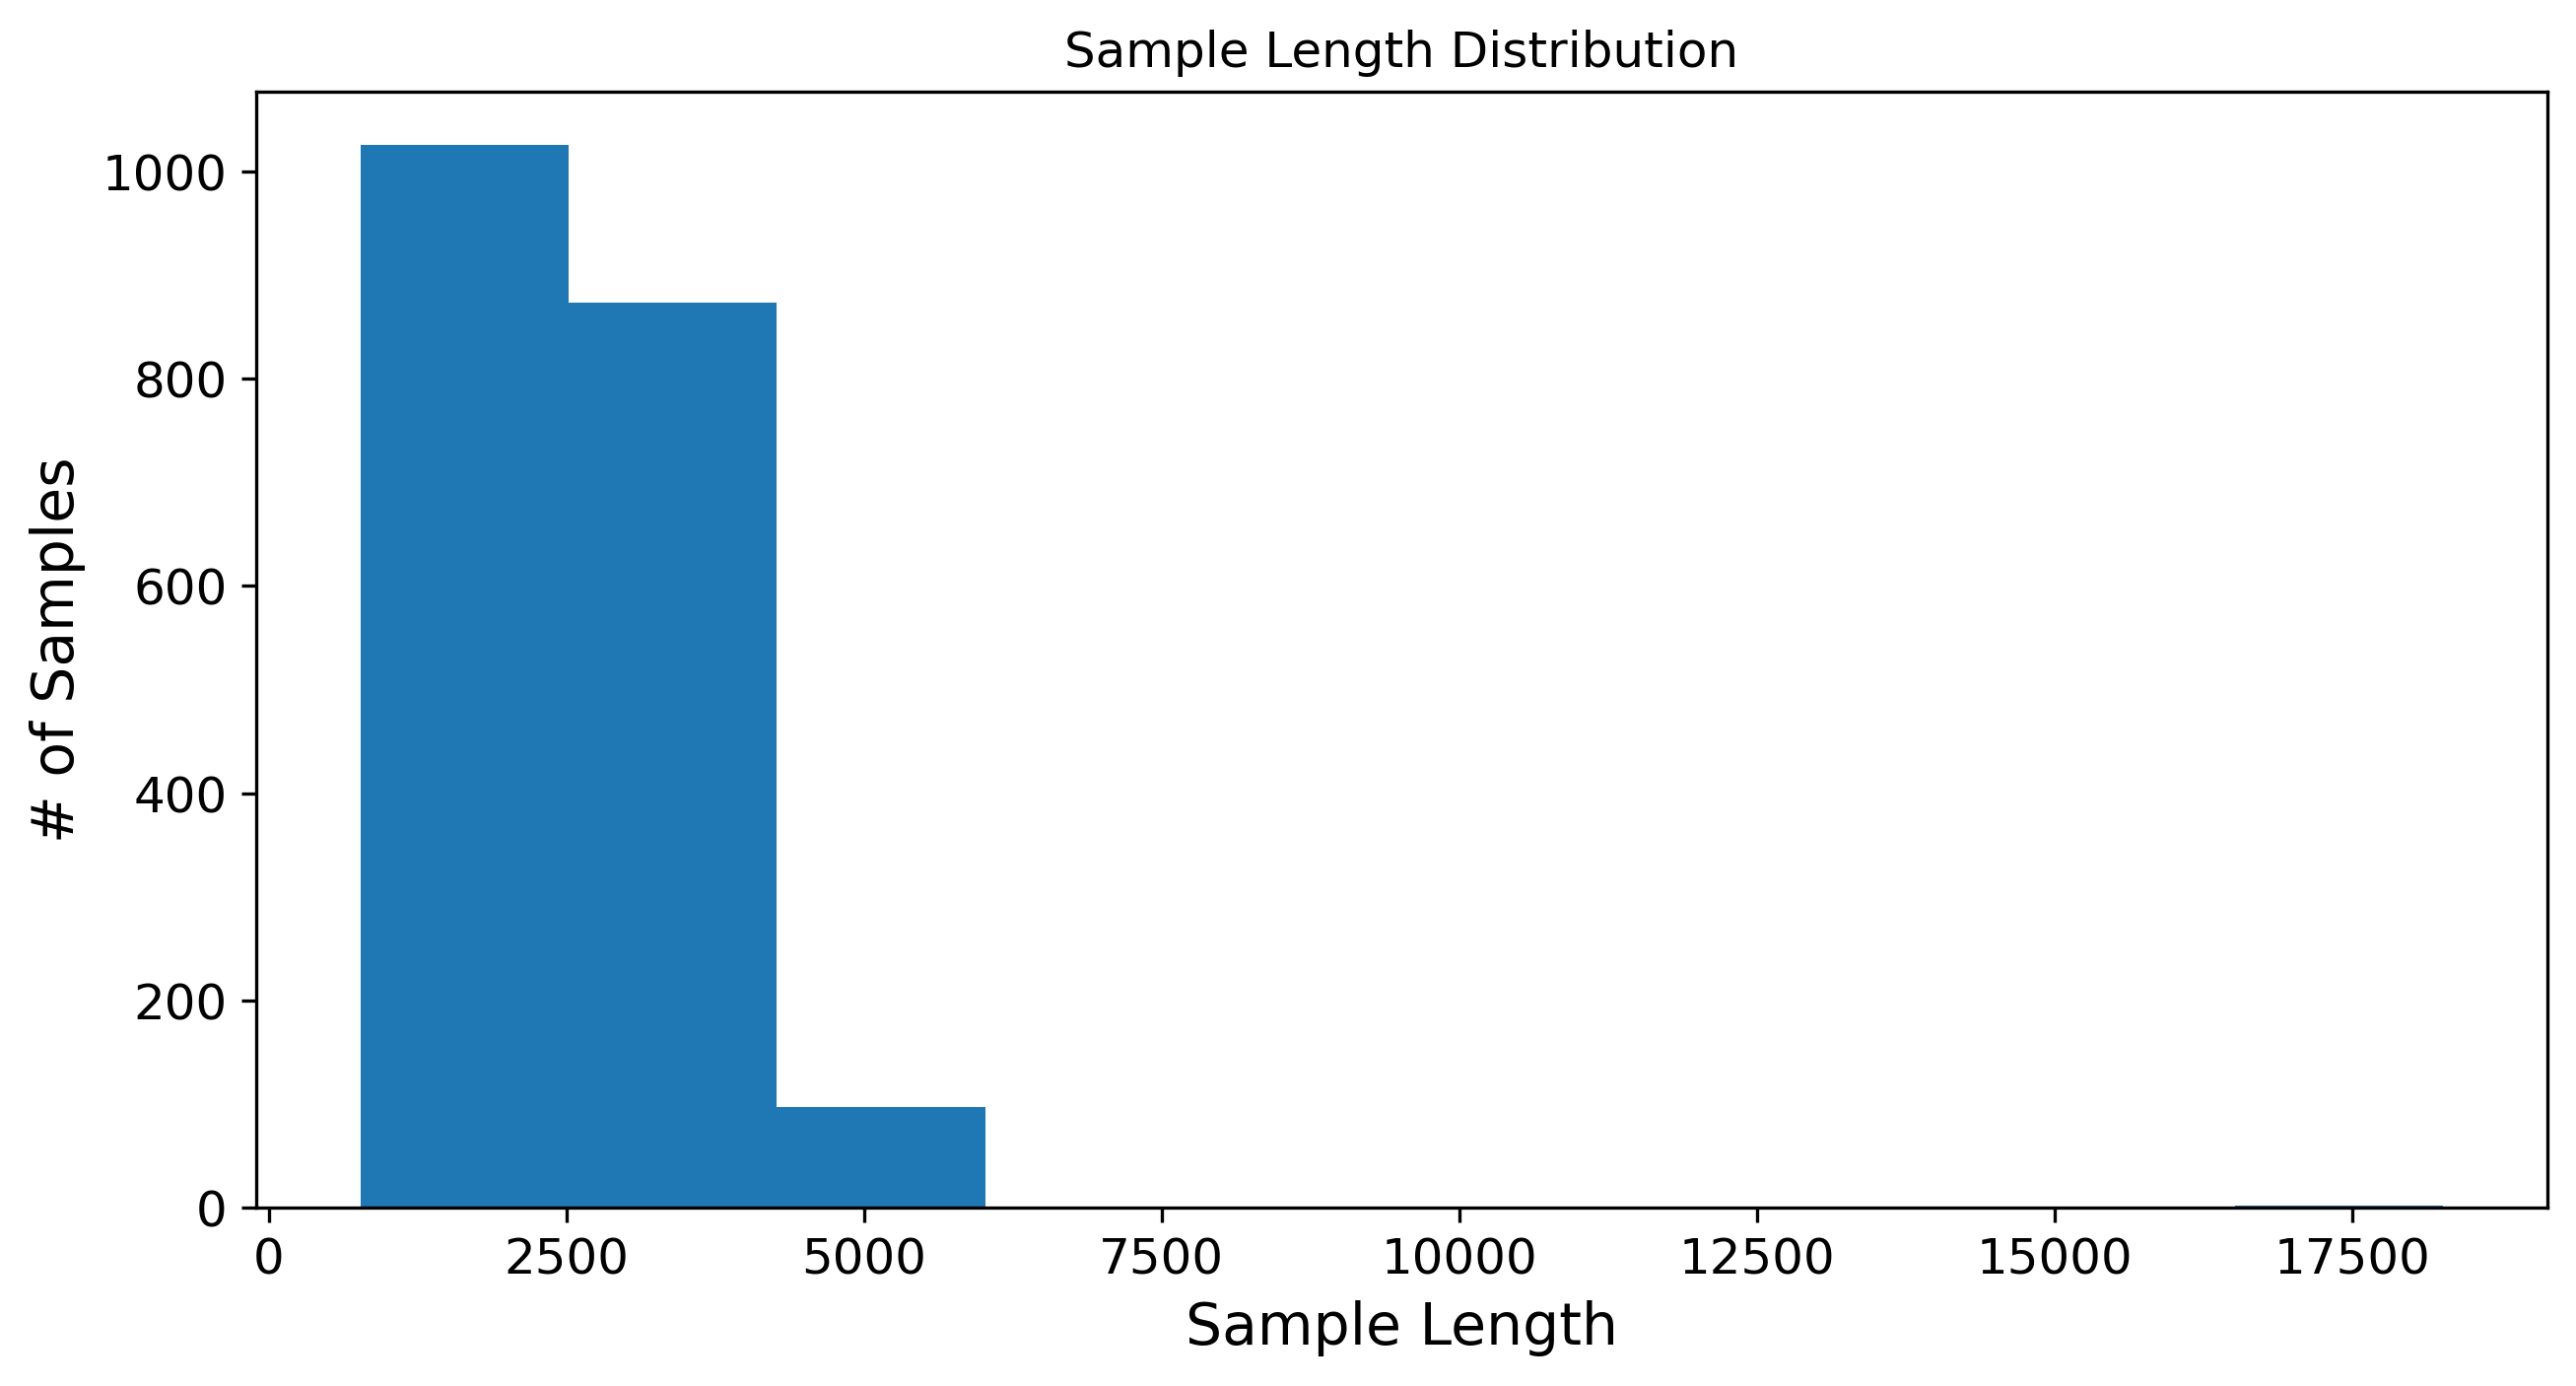

In [8]:
sample_len = [len(x) for x in audios]

plt.hist(sample_len)
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("# of Samples")
plt.show()

In [9]:
print("5th Percentile: ",np.percentile(sample_len,5))
print("10th Percentile: ",np.percentile(sample_len,10))
print("95th Percentile: ",np.percentile(sample_len,95))
print("97th Percentile: ",np.percentile(sample_len,97))

5th Percentile:  1280.0
10th Percentile:  1472.0
95th Percentile:  4277.549999999999
97th Percentile:  4523.12


In [10]:
i_dis.Audio(audios[0],rate=8000)

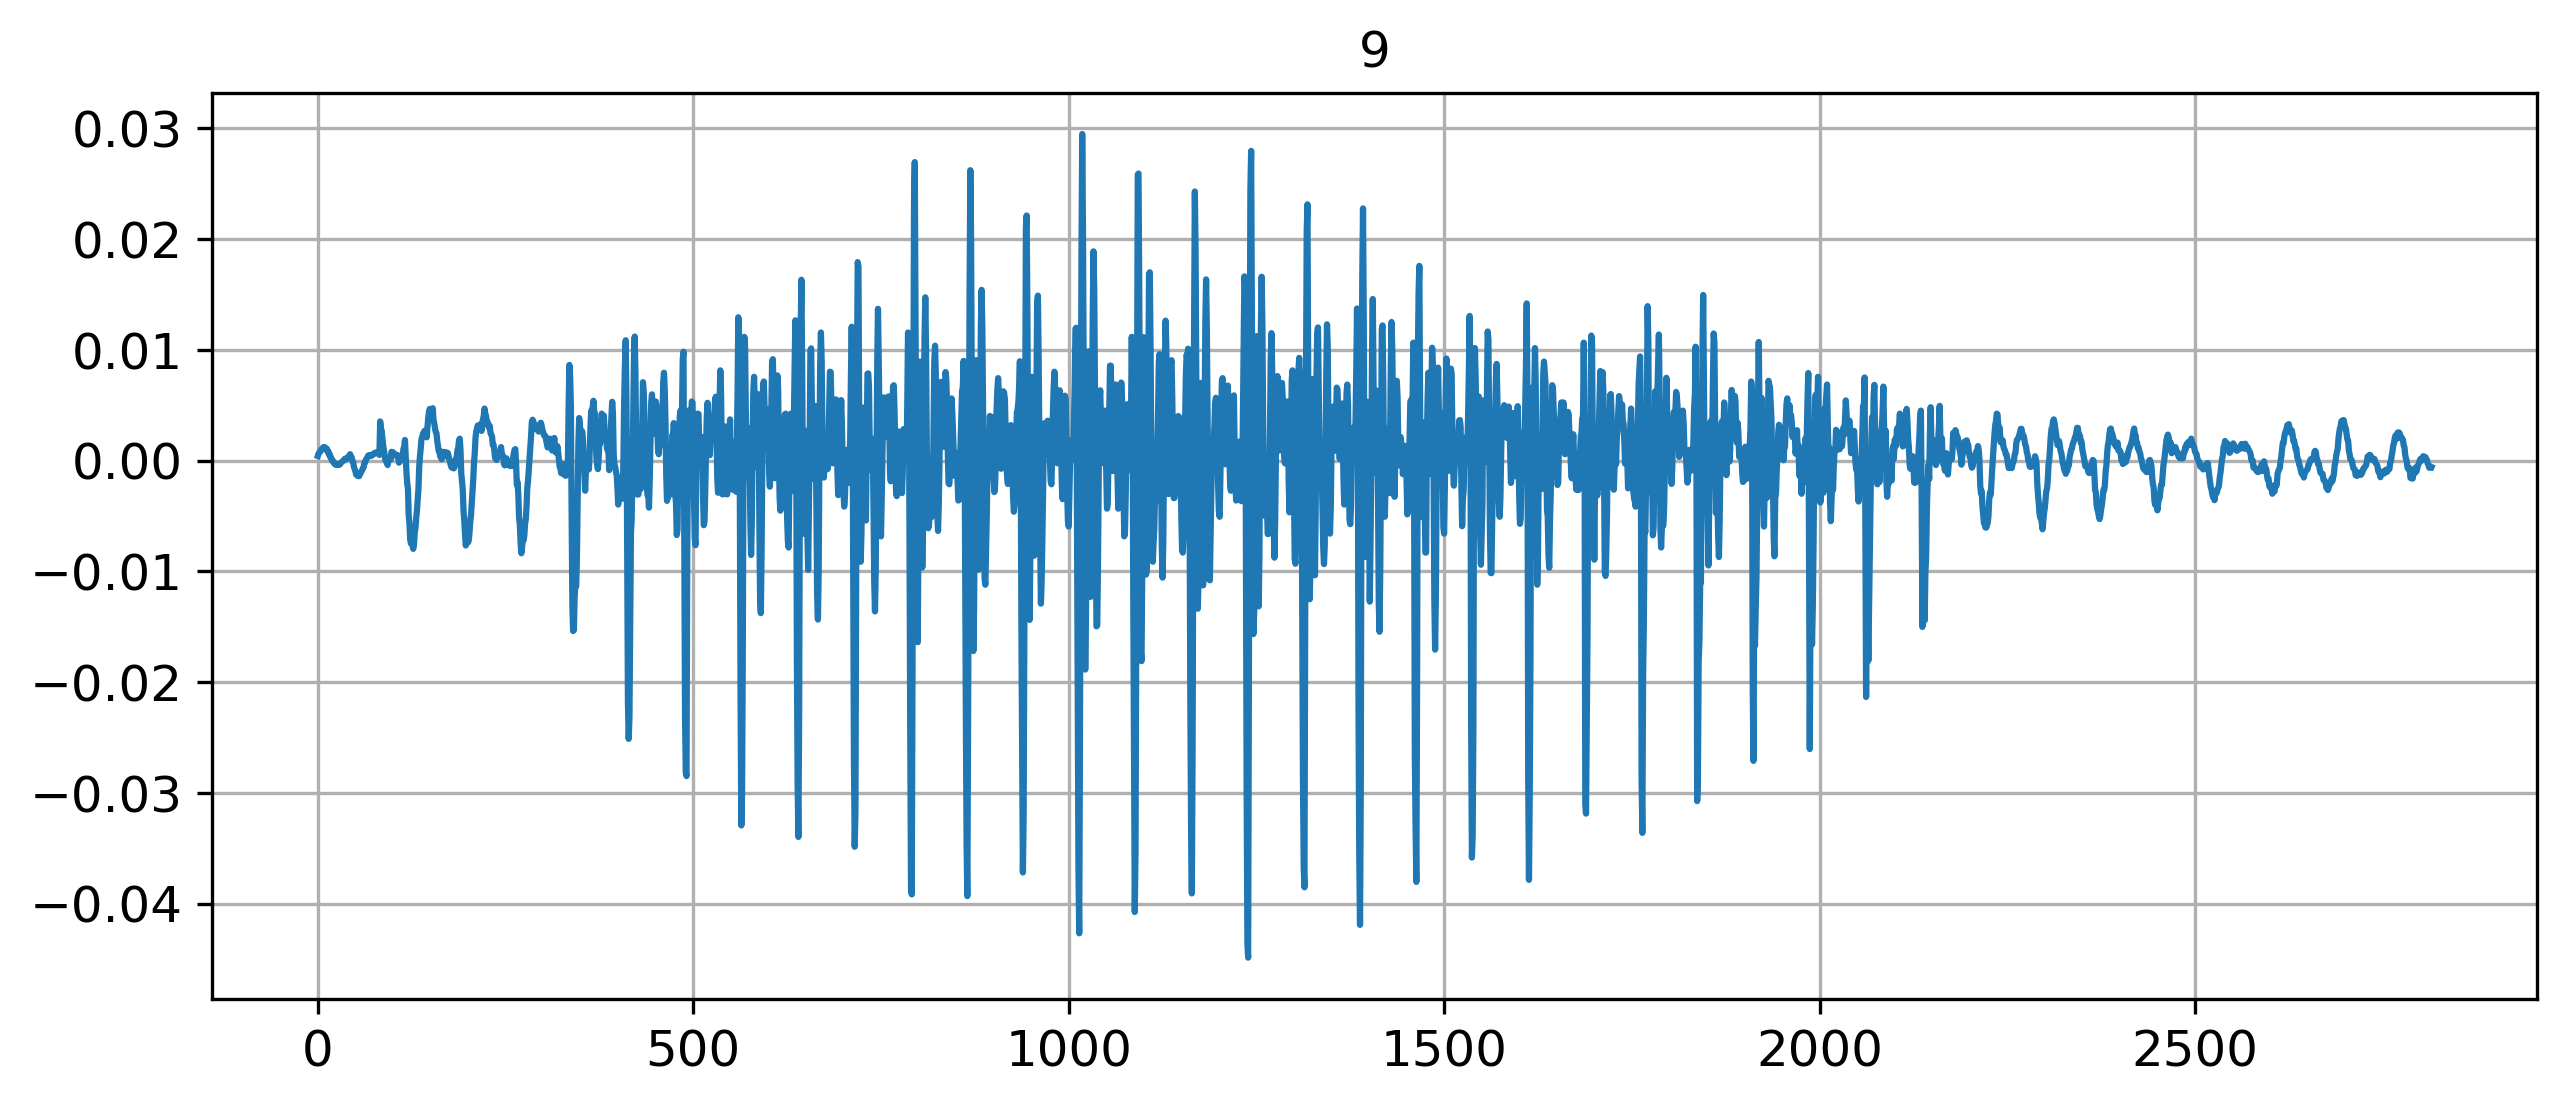

In [11]:
# librosa.display.waveplot(audios[0],sr=SR)
plt.figure(figsize=(10,4))
plt.title(labels[0])
plt.plot(audios[1000])
plt.grid("ON")
plt.show()

### Process Dataset

In [12]:
# trimming unncessary silence and adding some required silence
audios, SR, labels = fetch_data(length=4000)

Reading Data ... : 100%|██████████| 2000/2000 [00:01<00:00, 1596.80it/s]


In [13]:
sample_len = [len(x) for x in audios]
print(sample_len[0])

4000


All audio file is now 4000 samples or 0.5 seconds in length

In [14]:
i_dis.Audio(audios[0],rate=8000)

In [15]:
data = pd.Series(labels)

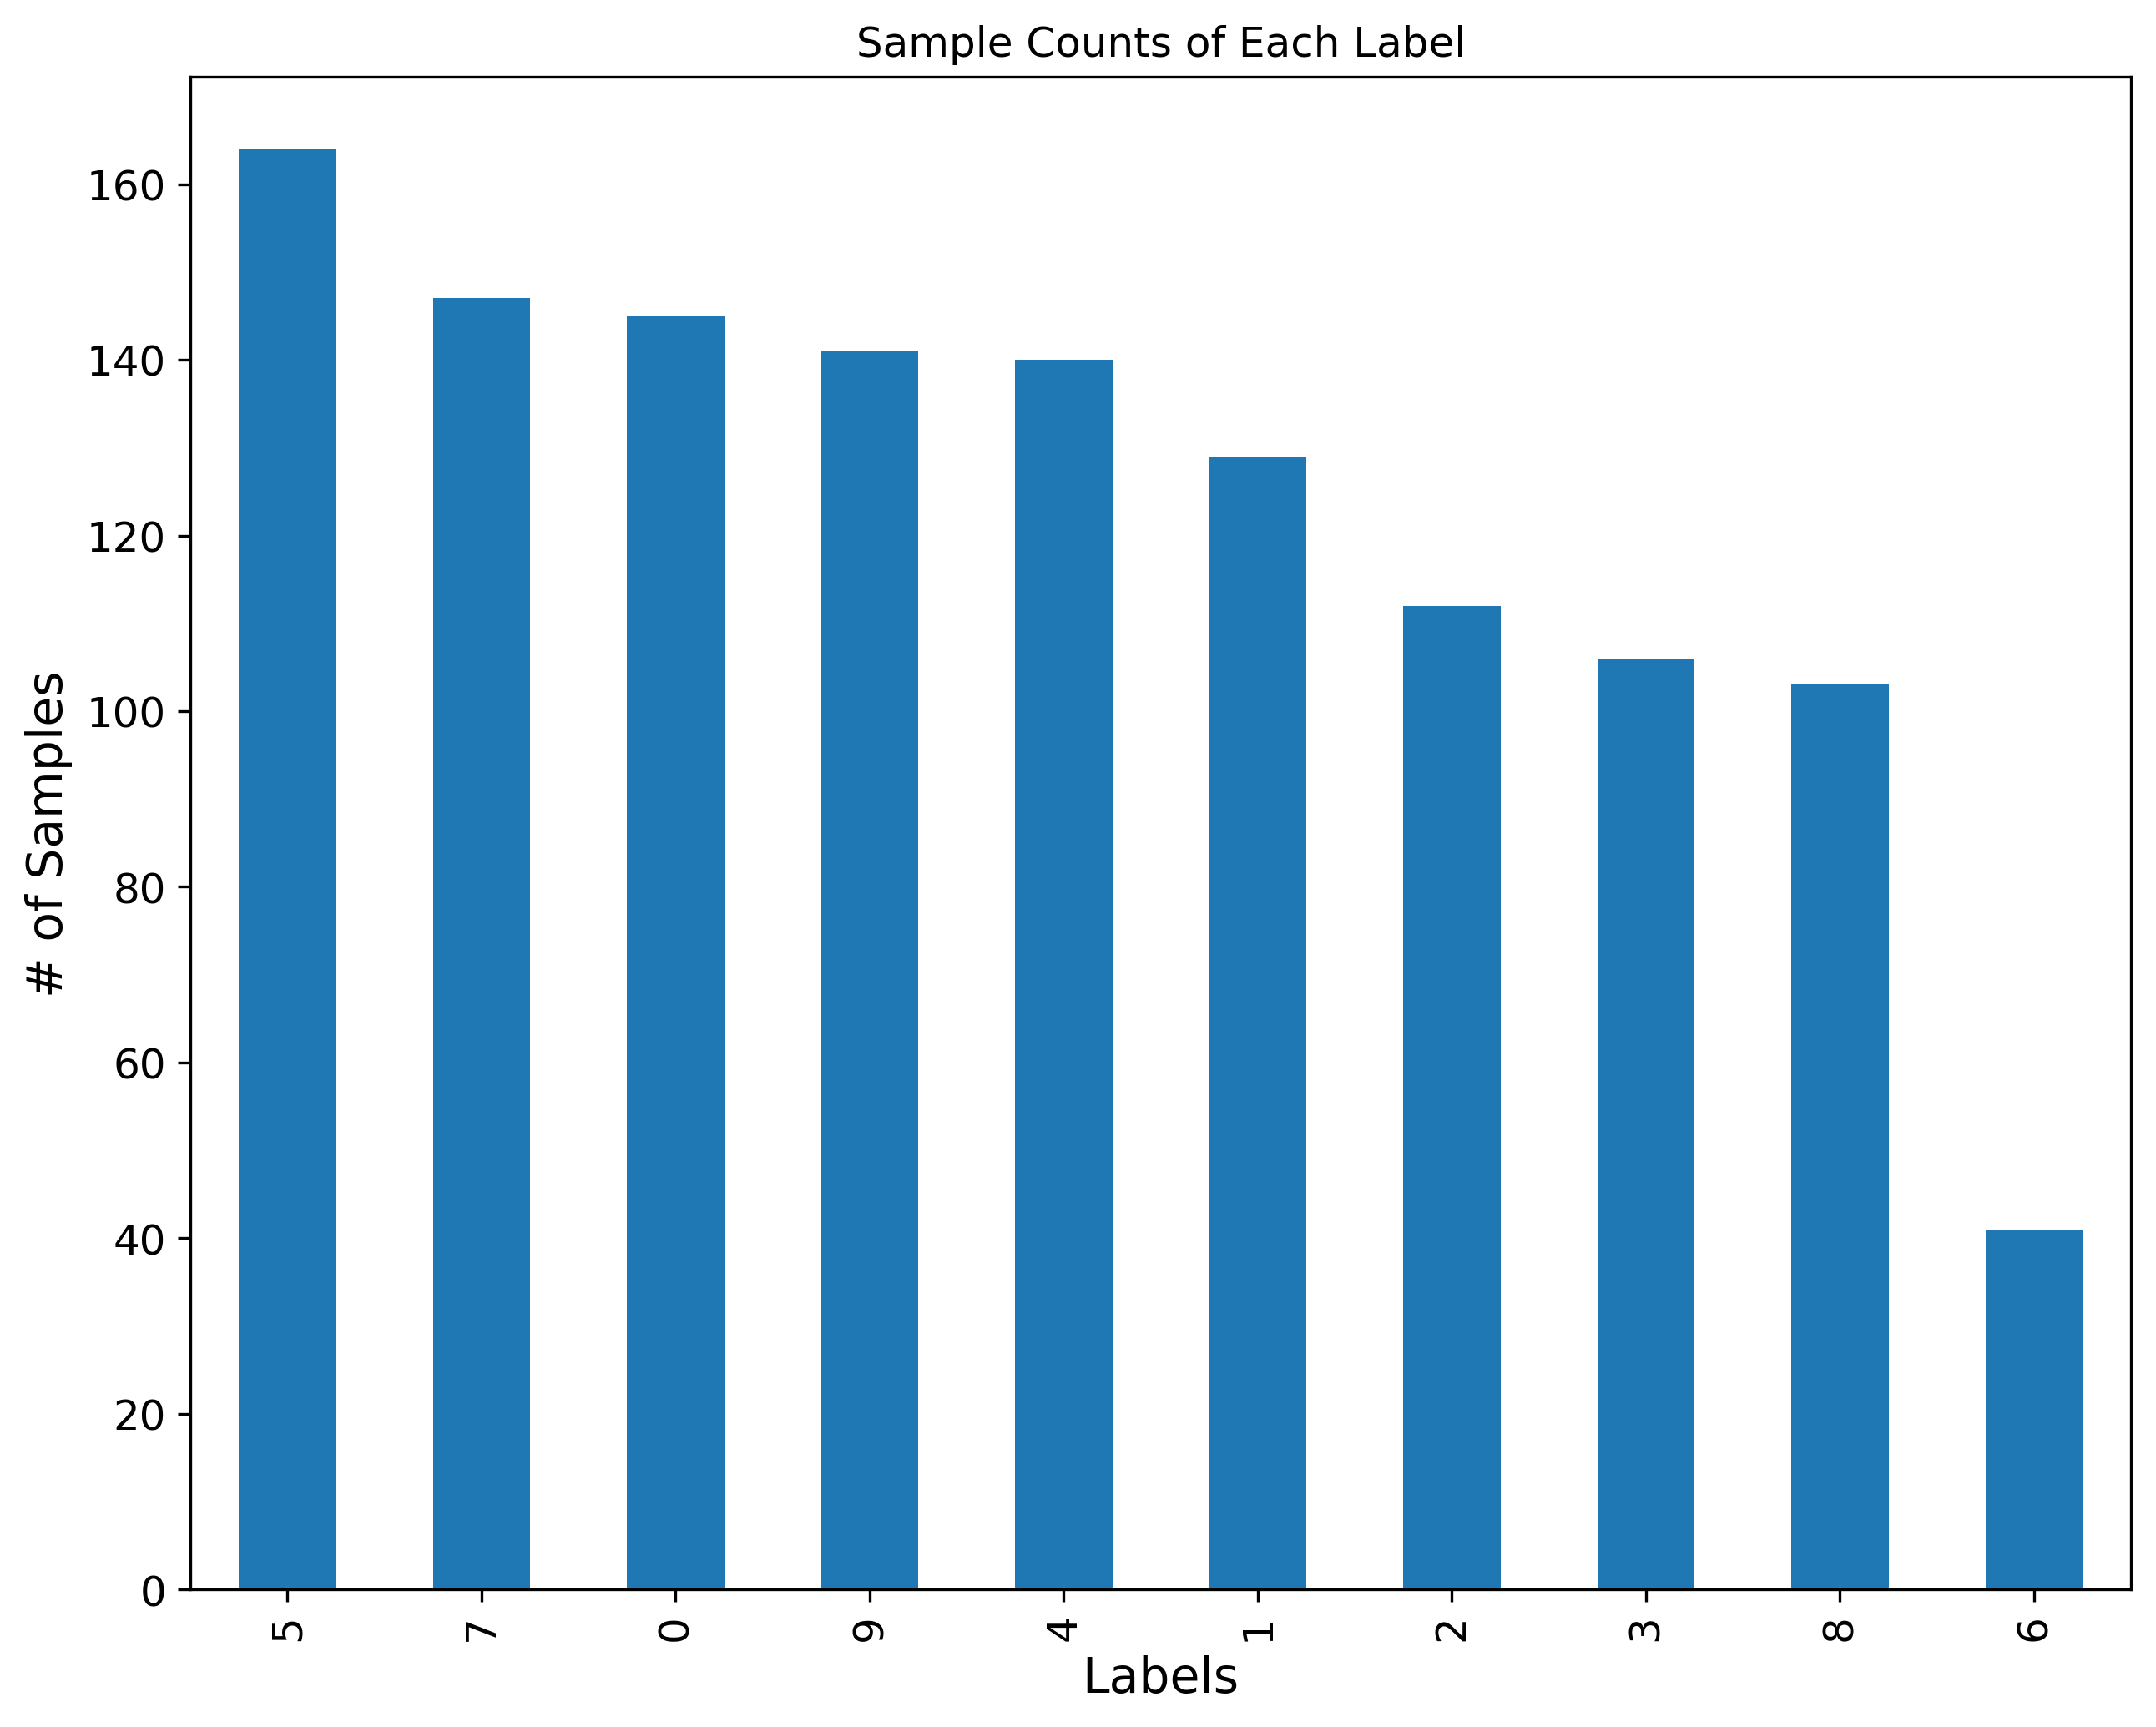

In [16]:
plt.figure(figsize=(10,8))
plt.title("Sample Counts of Each Label")
data.value_counts().plot(kind="bar")
plt.xlabel("Labels")
plt.ylabel("# of Samples")
plt.show()

In [17]:
len(audios),len(labels)

(1228, 1228)

## Data Processing

### Data Augmentation

### NOISE ADDITION

In [18]:
def add_noise(data, FACTOR=0.003):
    noise = np.random.randn(len(data))
    new_data = data + FACTOR * noise
    return new_data.astype(type(data[0]))
    

In [19]:
new_audios_noise = np.array(list(map(add_noise,audios)))

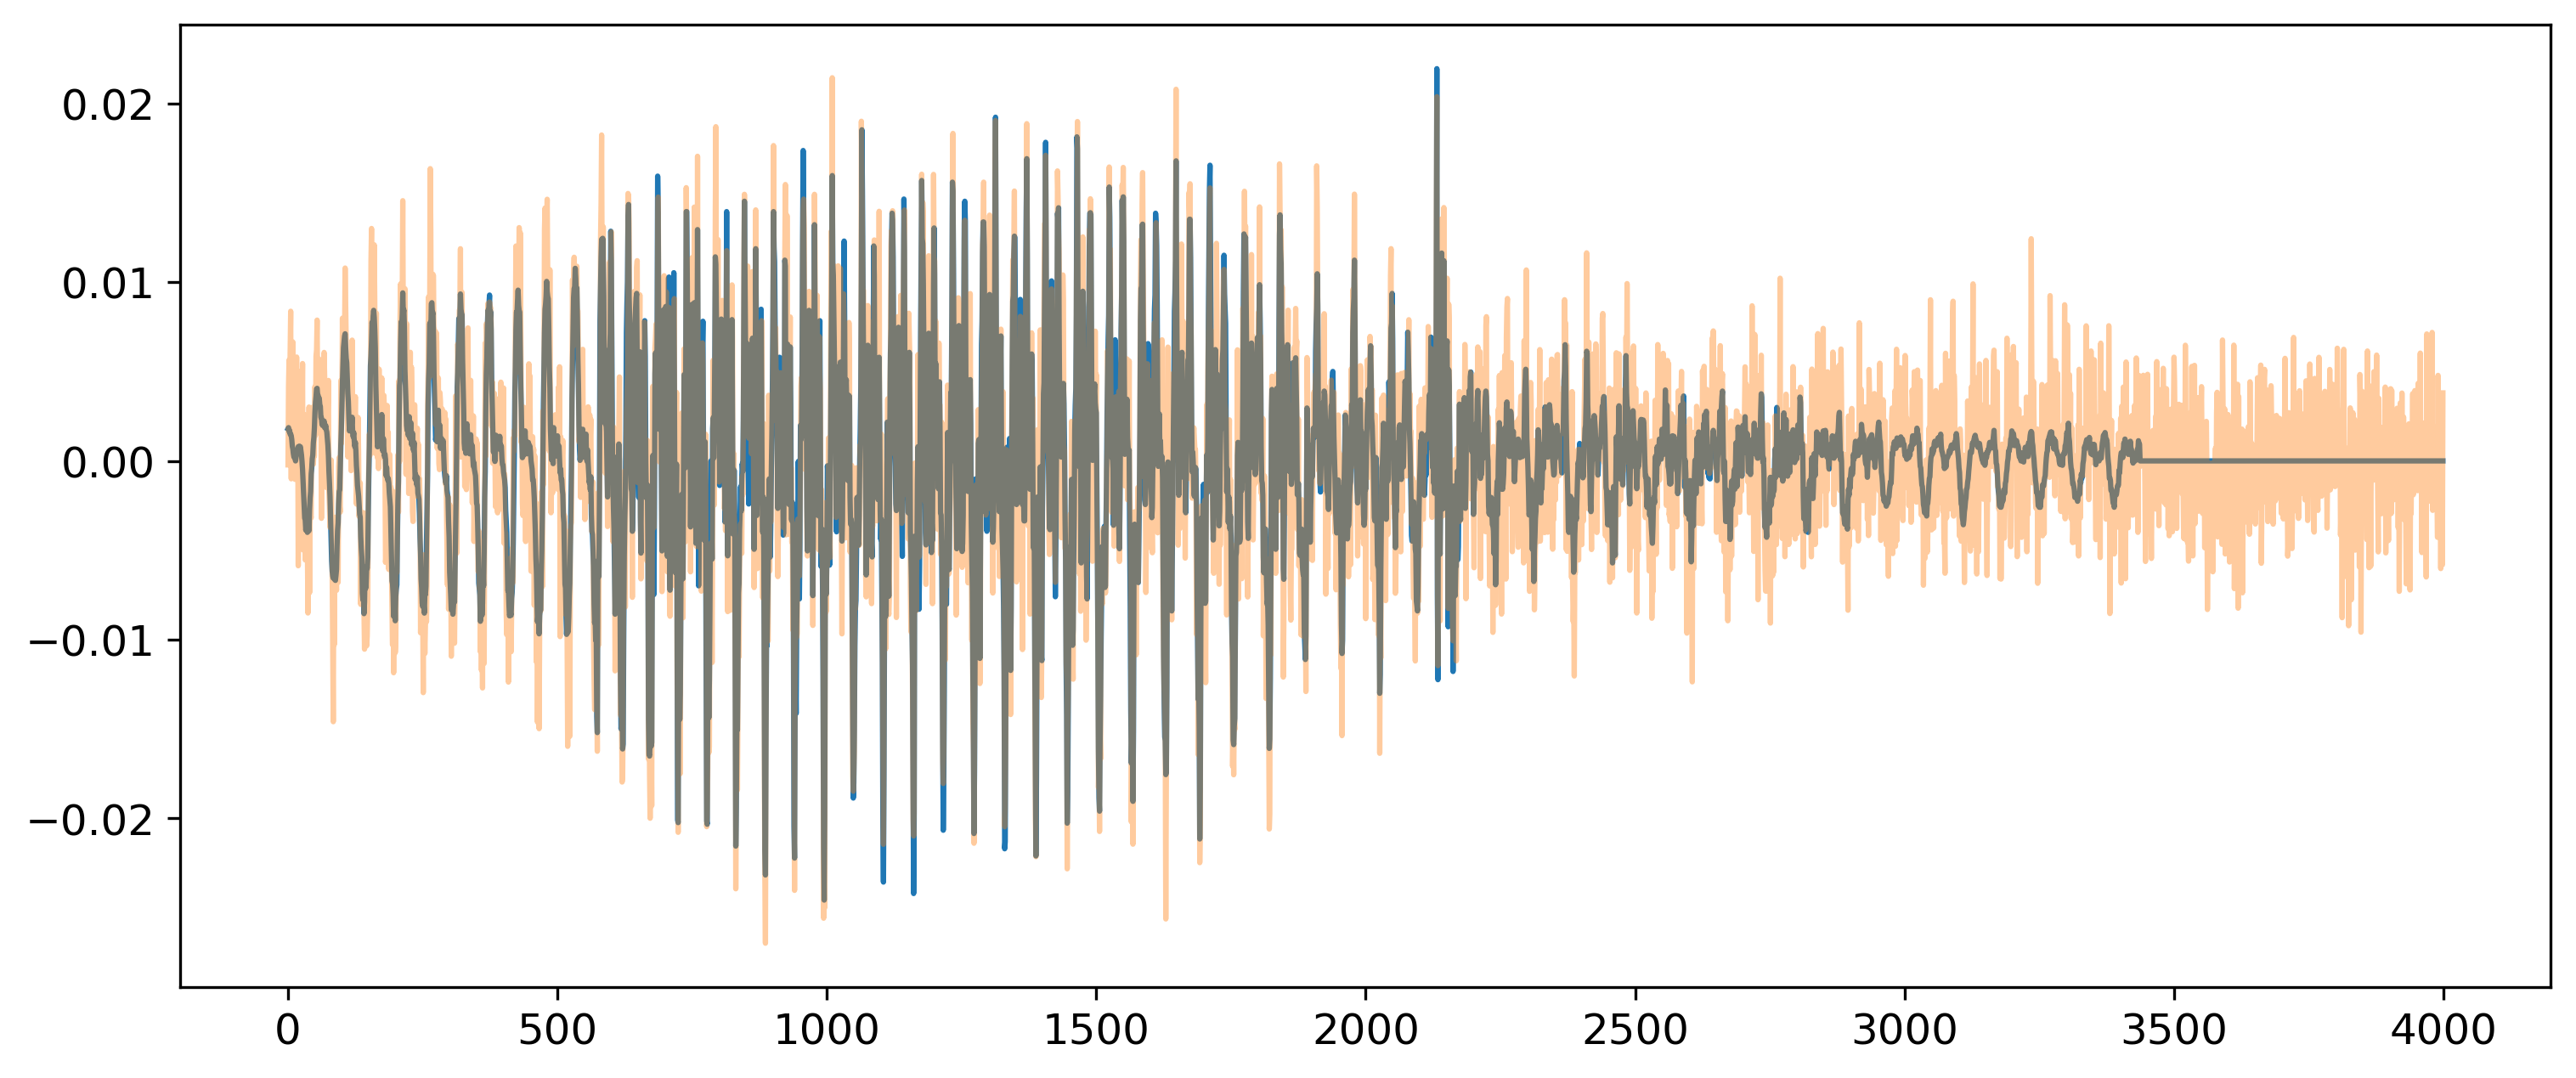

In [20]:
plt.figure(figsize=(12,5))
plt.plot(audios[0])
plt.plot(new_audios_noise[0],alpha=0.4)
plt.show()

In [21]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [22]:
# manipulated audio
i_dis.Audio(new_audios_noise[0],rate=8000)

### TIME SHIFTING

In [23]:
def time_shift(data,SHIFT_LEN=300,SHIFT_DIR ="RIGHT"):
    if SHIFT_DIR != "RIGHT":
        SHIFT_LEN = - SHIFT_LEN
    shifted_data = np.roll(data,SHIFT_LEN)
    if SHIFT_LEN>0:
        shifted_data[:SHIFT_LEN] = 0
    else:
        shifted_data[SHIFT_LEN:] = 0
    return shifted_data

In [24]:
new_audios_shifted = np.array(list(map(lambda x: time_shift(x,SHIFT_DIR="LEFT"),audios)))

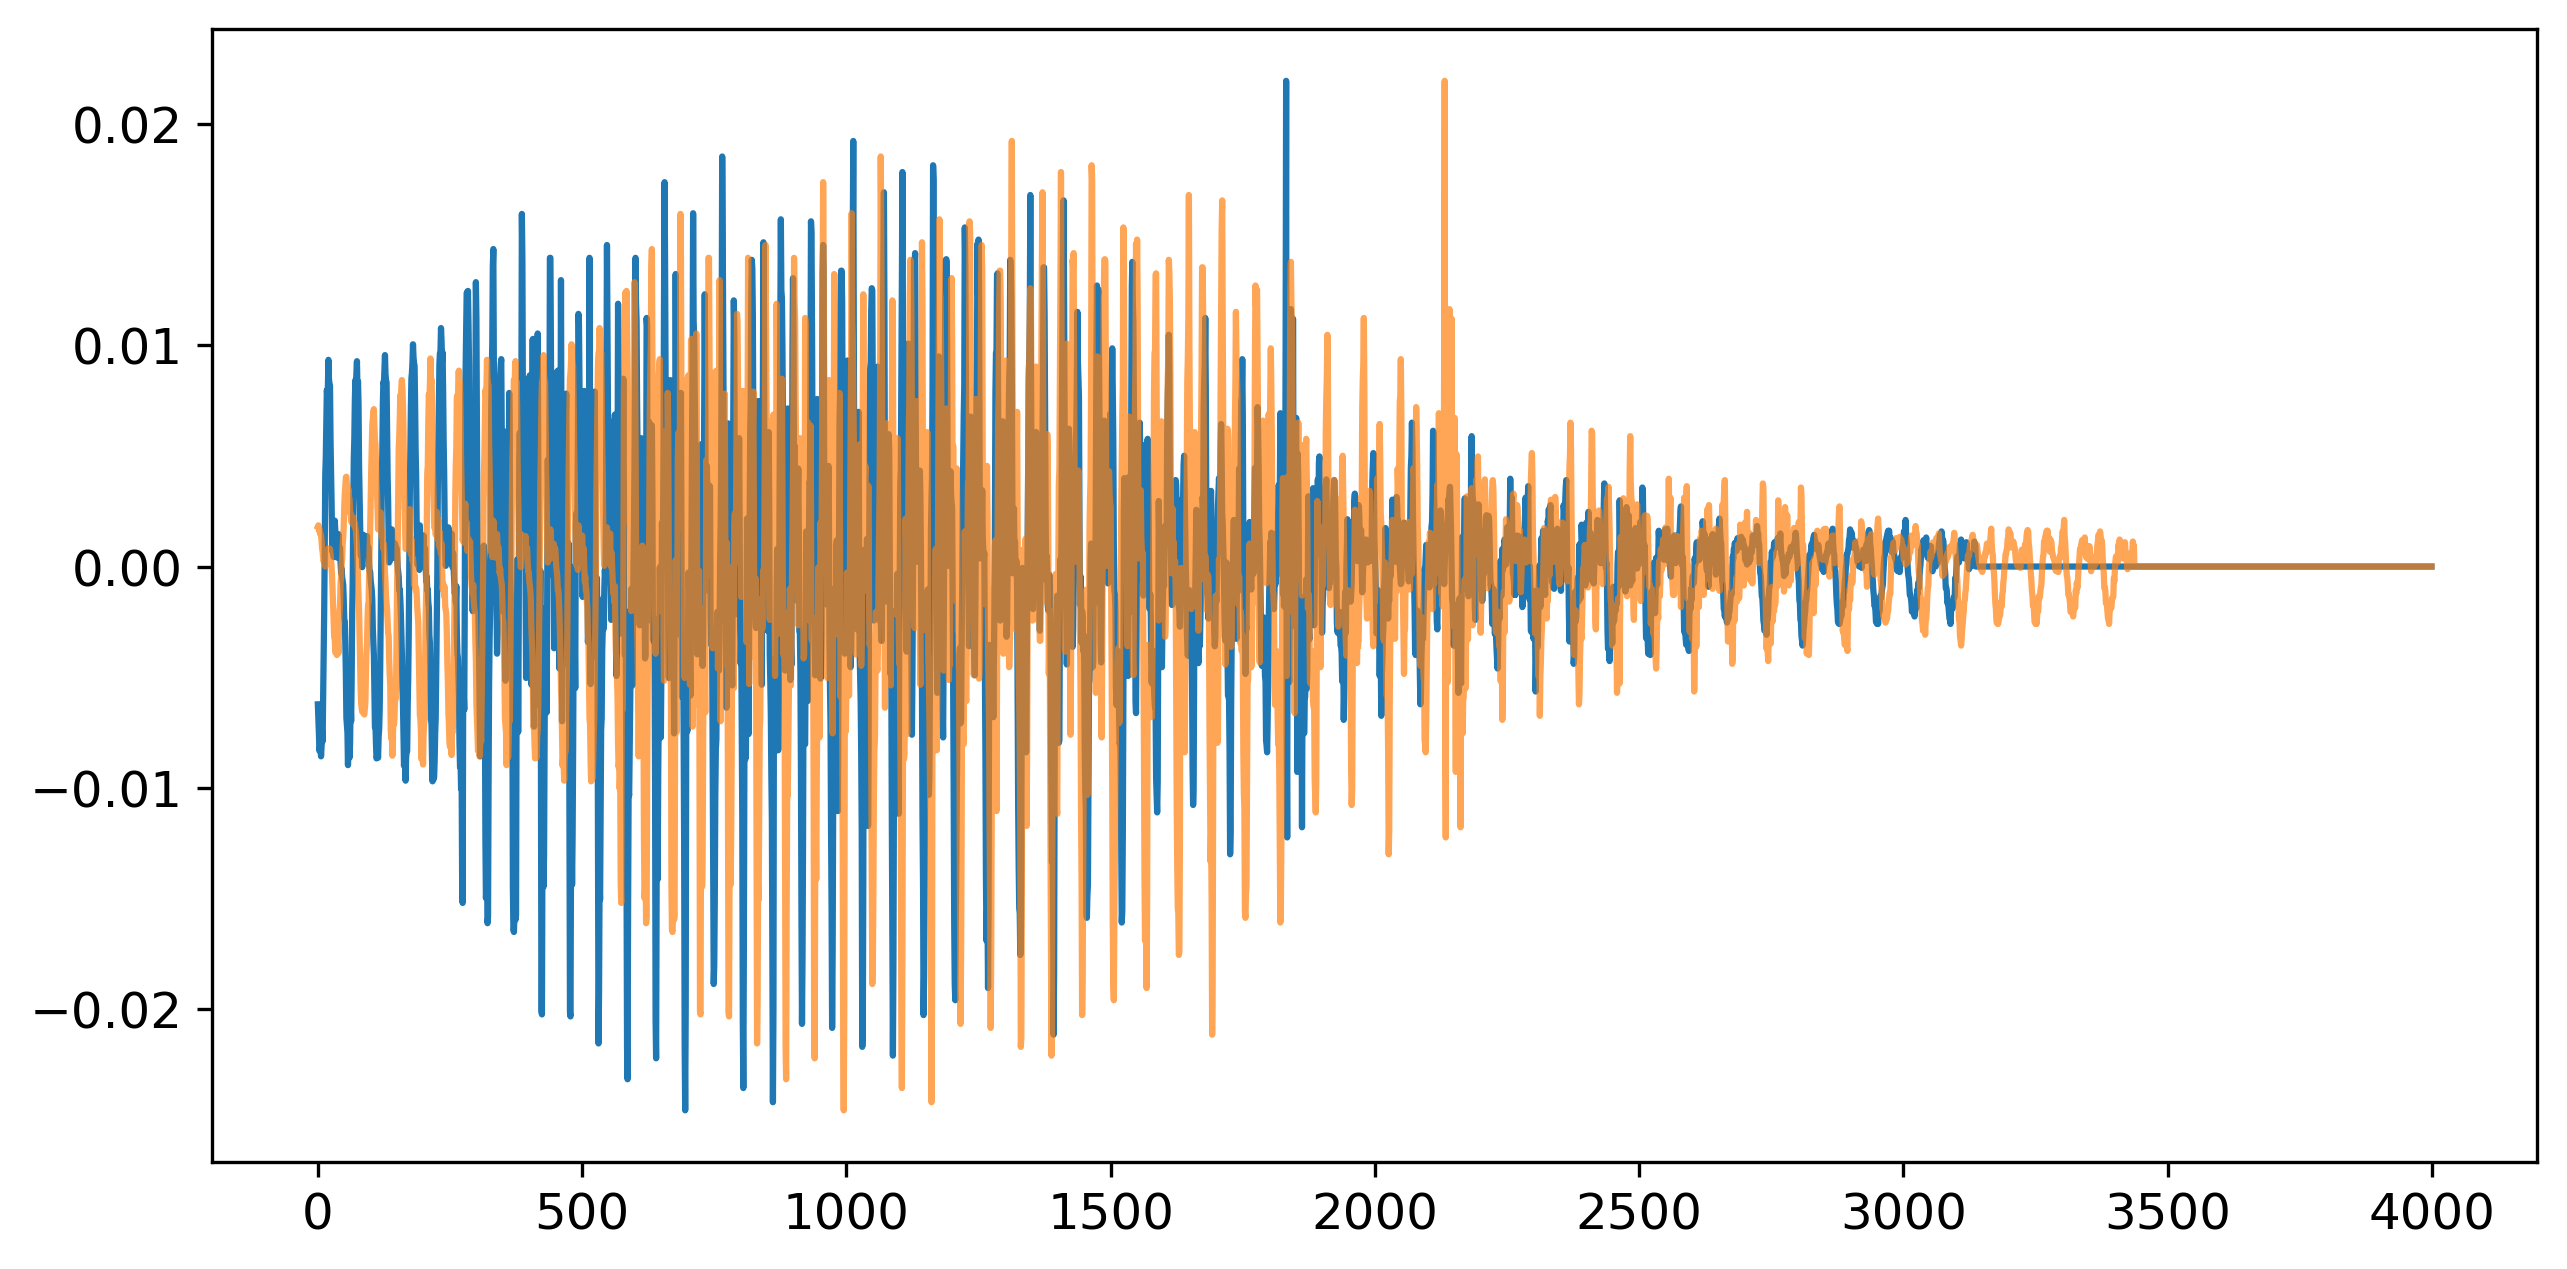

In [25]:
plt.plot(new_audios_shifted[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [26]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [27]:
# original audio
i_dis.Audio(new_audios_shifted[0],rate=8000)

### CHANGING PITCH

In [28]:
def change_pitch(data,sr=8000,FACTOR=0.1):
    return librosa.effects.pitch_shift(data,SR,FACTOR)

In [29]:
new_audios_pitch = np.array(list(map(change_pitch,audios)))

plt.plot(new_audios_pitch[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [30]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [31]:
# manipulated audio
i_dis.Audio(new_audios_pitch[0],rate=8000)

### CHANGING SPEED

In [32]:
def change_speed(data,RATE=0.5):
    """
    change speed of the given sample
    if rate < 0 --> audio becomes slower
    if rate > 0 --> audio becomes faster
    """
    return librosa.effects.time_stretch(data,RATE)

In [33]:
new_audios_speed = np.array(list(map(change_speed,audios)))

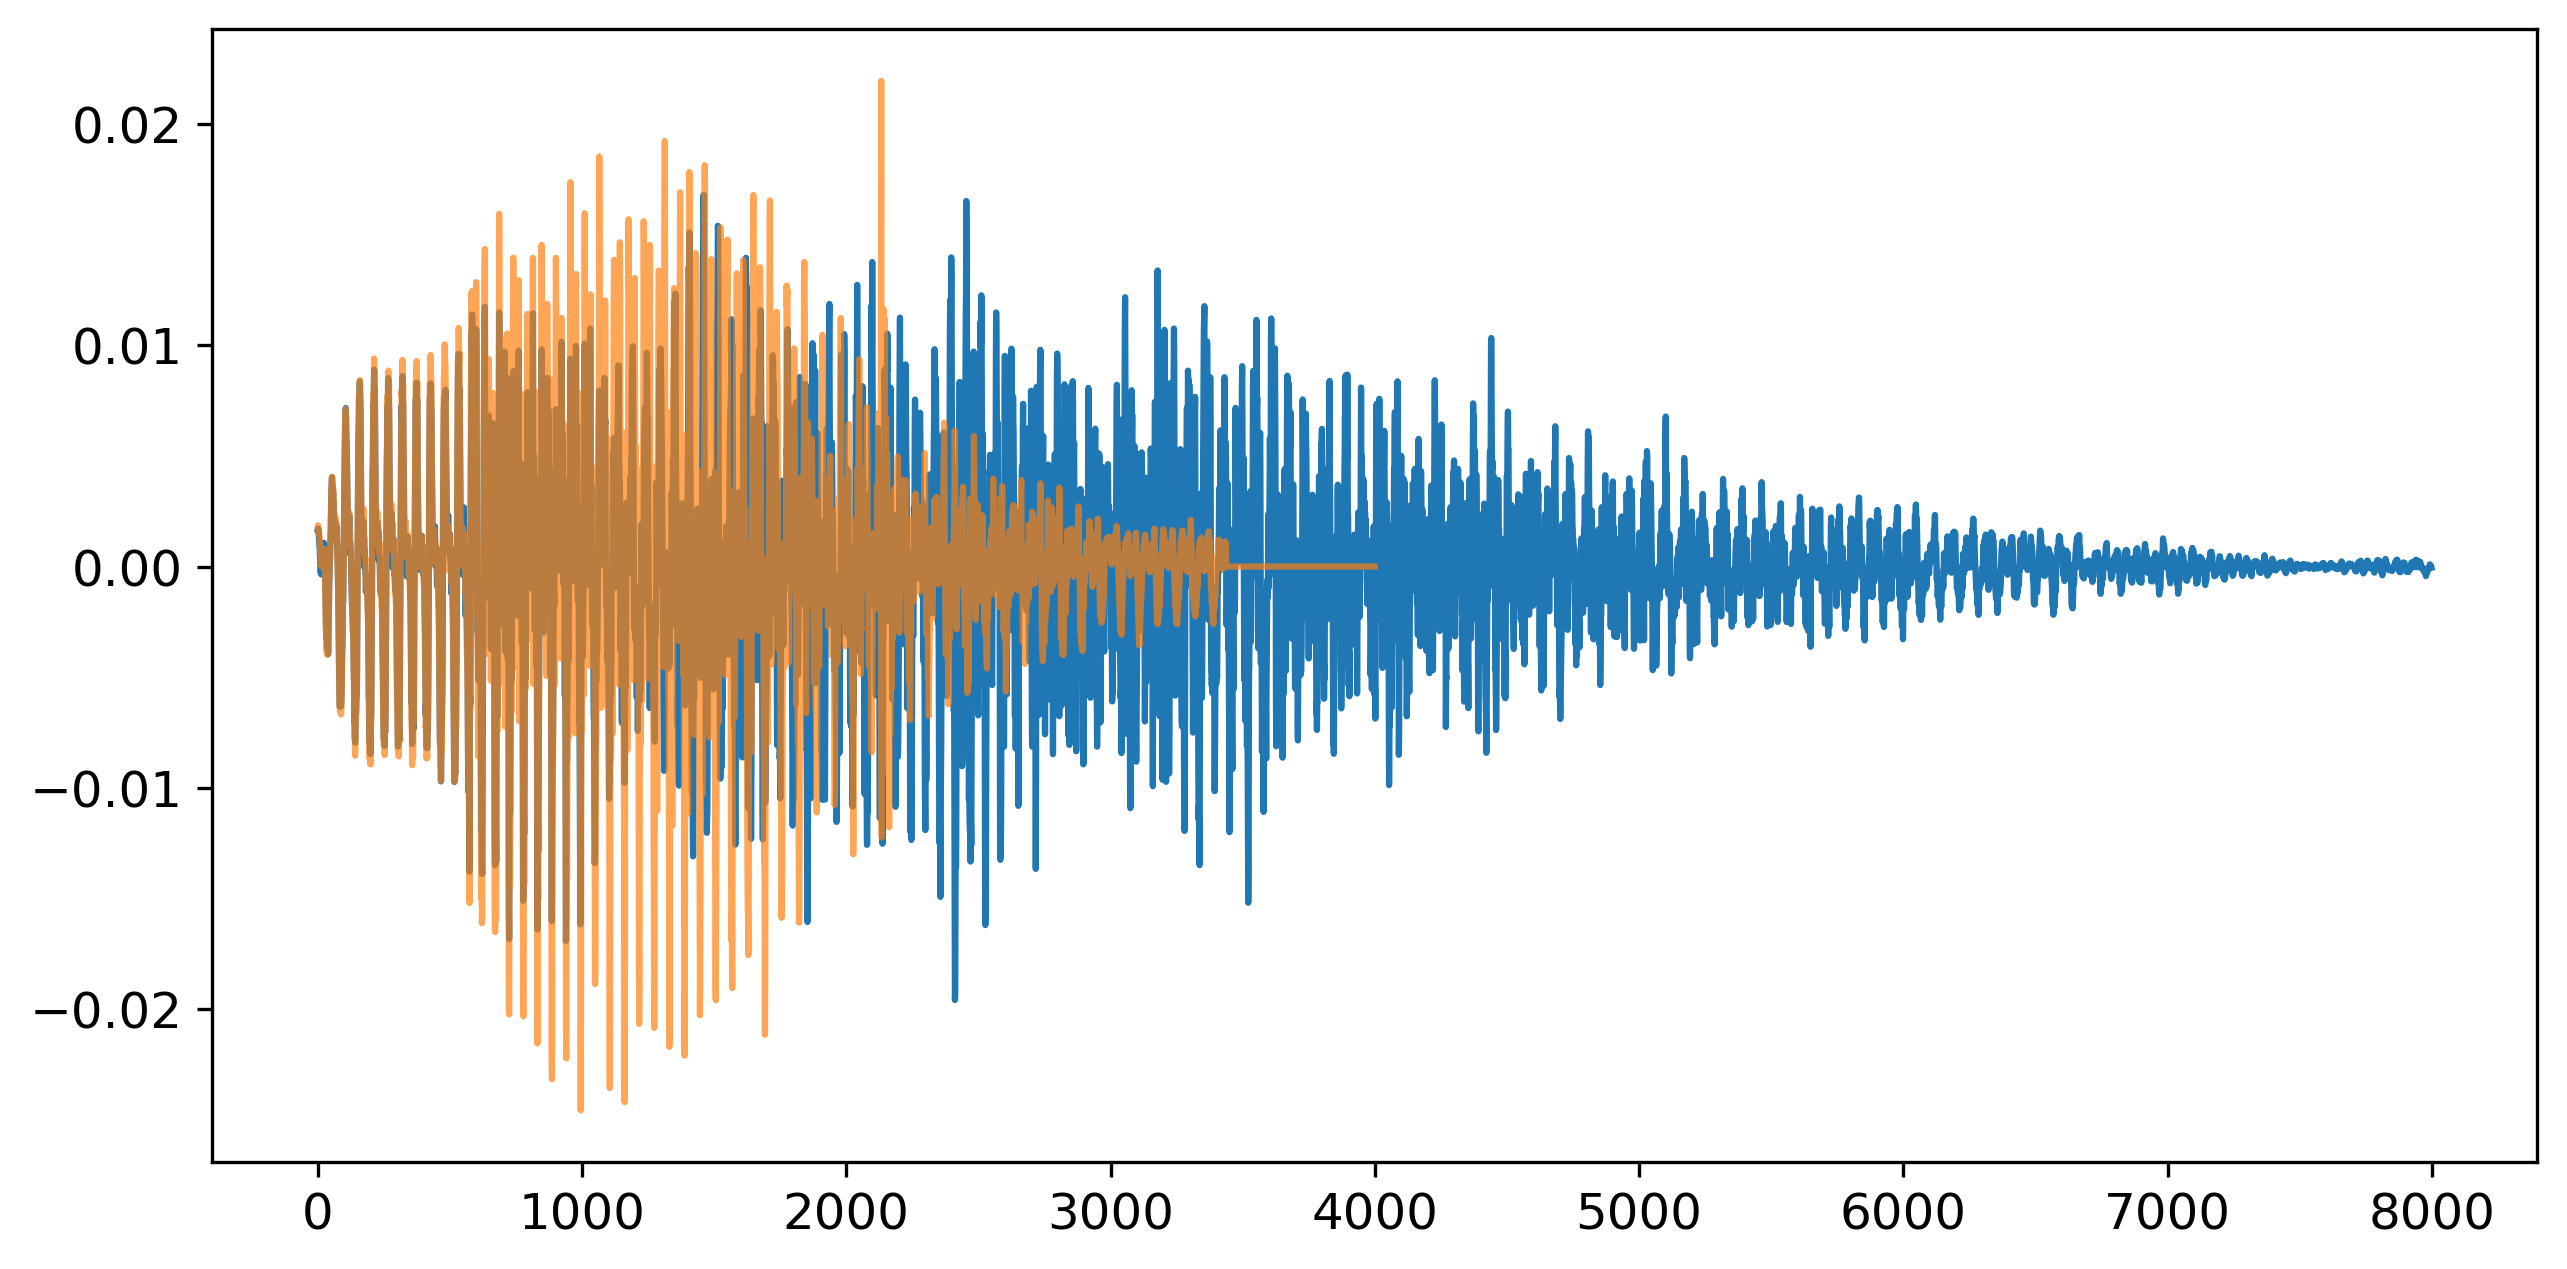

In [34]:
plt.plot(new_audios_speed[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [35]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [36]:
# manipulated audio
i_dis.Audio(new_audios_speed[0],rate=8000)

In [37]:
len(new_audios_speed[0])

8000

In [48]:
print("Data shape before augmentation: ")
print(audios.shape)
print(labels.shape)

all_data = np.vstack((audios, new_audios_noise, new_audios_pitch,new_audios_shifted)) 
all_labels = np.hstack((labels,labels,labels,labels))
print("Data shape after augmentation: ")
print(all_data.shape)
print(all_labels.shape)


Data shape before augmentation: 
(1228, 4000)
(1228,)
Data shape after augmentation: 
(4912, 4000)
(4912,)


### Extract Features

In [39]:
def extract_MFCC(audio,SR,n_mfcc=20,hop_length=125,n_fft=256):
    features = []
    for a in tqdm.tqdm(audio,desc="Extracting Features: "):
        mfcc = librosa.feature.mfcc(a,sr=SR,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft)
        features.append(mfcc.T)
    return np.array(features)

In [40]:
features = extract_MFCC(all_data,SR)

Extracting Features: 100%|██████████| 4912/4912 [00:30<00:00, 161.21it/s]


[Text(0.5, 1.0, 'MFCC')]

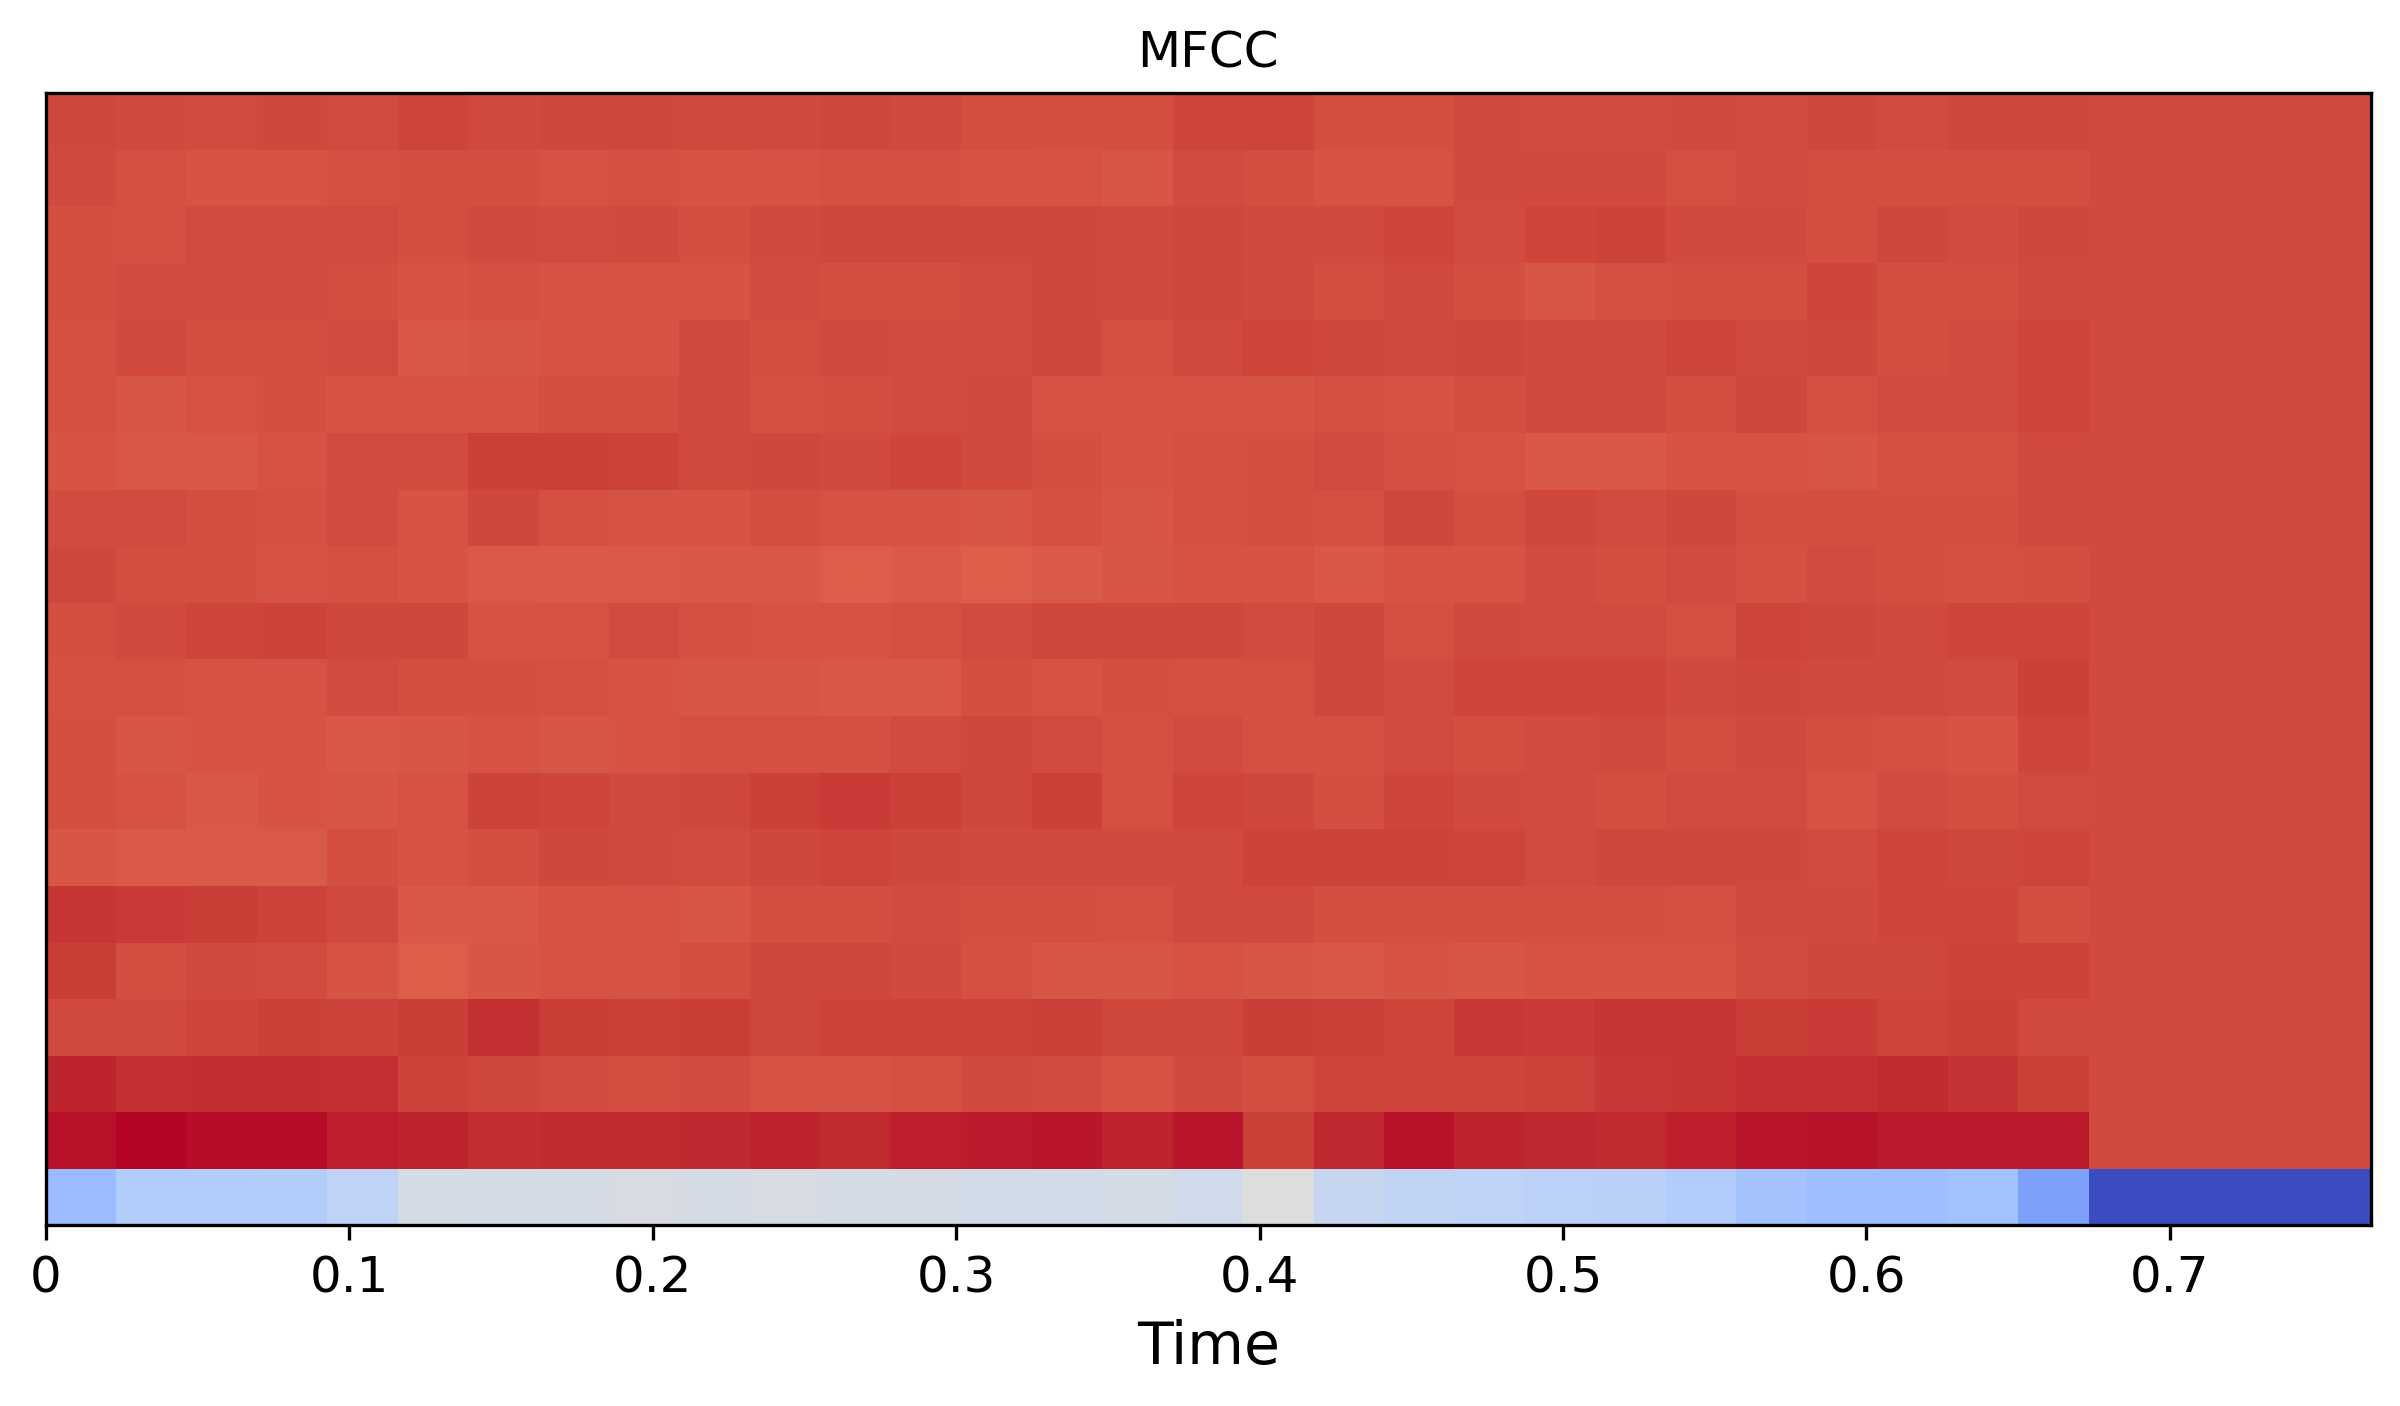

In [41]:
fig, ax = plt.subplots()
img = display.specshow(features[0].T, x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [42]:
data_dict = {"X":features,"Y":all_labels}
print(len(features),len(all_labels))
print(data_dict.keys())

4912 4
dict_keys(['X', 'Y'])


In [43]:
pickle.dump(data_dict,open(os.path.join(DATA_DIR,"..","data.pickle"),"wb"))

### Encode Labels

In [44]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels).astype('float64')

In [45]:
X = np.array(features)
Y = encoded_labels

In [46]:
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)

train_id, test_id = next(splitter.split(X,Y))
X_train,y_train,X_test,y_test = X[train_id],Y[train_id],X[test_id],Y[test_id]

train_id, test_id = next(splitter.split(X_train,y_train))
X_train,y_train,X_val,y_val = X_train[train_id],y_train[train_id],X_train[test_id],y_train[test_id]

ValueError: Found input variables with inconsistent numbers of samples: [4912, 1228]

In [ ]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
print(X_train[0].shape)
print(X_train.shape)
print(X_test.shape)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=INPUT_SHAPE,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [ ]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)

In [ ]:
history = model.fit(X_train,y_train,epochs=30,batch_size=30,validation_data=(X_val,y_val),callbacks=[earlystop_callback])

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

In [ ]:
os.chdir(SAMPLE_DIR)

In [ ]:
i_dis.Audio("0_rabin_0.wav")

In [ ]:
sample,gan = librosa.load("0_rabin_0.wav",sr=None)

In [ ]:
len(sample)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sample)
plt.grid("ON")
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
off = int(len(sample)/2)
# sample =sample[:4000]
plt.plot(trimmed[:4000])
plt.grid("ON")
plt.show()

In [ ]:
trimmed, index = librosa.effects.trim(sample,top_db=10,frame_length=256, hop_length=64)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(trimmed)
plt.grid("ON")
plt.show()

In [ ]:
len(trimmed)

In [ ]:
index

In [ ]:
mfcc = librosa.feature.mfcc(sample[:4000],sr=gan,n_mfcc=13,hop_length=256,n_fft=2048)

In [ ]:
mfcc.shape

In [ ]:
mfcc = mfcc[...,np.newaxis]

In [ ]:
mfcc = mfcc[np.newaxis,...]

In [ ]:
mfcc.shape

In [ ]:
model.predict_classes(mfcc)

In [ ]:
real_data = []
real_labels = []
LENGTH = 4000
THRESHOLD = 2000

for file in os.listdir():
    sample,sr = librosa.load(file,sr=None)
    sample, index = librosa.effects.trim(sample,top_db=15,frame_length=256, hop_length=64)
    if(len(sample)>LENGTH):
        sample = sample[:LENGTH]
    if(len(sample)<THRESHOLD):
        print("Corrupt file")
        continue
    if(len(sample)<LENGTH):
        sample = np.pad(sample,(0,LENGTH-len(sample)),constant_values=(0,0))
    mfcc = librosa.feature.mfcc(sample,sr=sr,n_mfcc=20,hop_length=125,n_fft=256)
    real_data.append(mfcc.T)
    real_labels.append(float(file[0]))
    mfcc = mfcc.T[np.newaxis,...,np.newaxis]
    p = model.predict_classes(mfcc)
    print(int(p), end="   ")
    print(file[0])

print(len(real_data))
print(type(real_data))

real_data =np.array(real_data)
real_labels = np.array(real_labels)
real_data = real_data[...,np.newaxis]
model.evaluate(real_data,real_labels)

In [ ]:
os.listdir()

In [ ]:
print(real_labels)

In [ ]:
model.predict_classes(real_data)

In [ ]:
model.predict_classes(real_data[0][np.newaxis,...])

In [ ]:
real_data[0].shape